# Pan-Svalbard Pyplume!

This jupyter notebook can be used to run pyplume using ocean forcings from a set of csv files provided by Tomas Torsvik, and discharge and terminus depths from a .mat file provided by Jack Kohler.

You will also need pyplume and svalmap (svalmap is only required for plotting results) in folders in your python path, as well as the TEOS-10/python-gsw package (https://github.com/TEOS-10/python-gsw/). Note: this is the old TEOS-10 package - pyplume and the code here *should* be updated for Python 3 and the new TEOS-10 package!

The code is written to work with the following folder structure:

Code_folder/
    - SvalPlumes.ipynb
    - inputs/
        - ts_roms/
            - TW_0584_S800_refpoint.csv
            - TW_XXXX_S800_refpoint.csv
            - etc...
        - Major_2015_TW_Outlets_2019_03_06.mat
    
First do some generic imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import os

from pyplume import pyplume, const

import math
import gsw

%matplotlib inline

### A collection of helper functions to handle input data

The input folder locations and naming convention for TS files are also set here. If the formatting/filenames of input files changes, these will need updating

In [2]:
ts_folder = 'inputs/ts_roms/'

ts_fname_prefix = 'TW_'

ts_fname_suffix = '_S800_refpoint.csv'

def roms_csv_to_df(fname):
    '''Reads a csv file dumped from ROMS and returns a pandas dataframe.
    
    This function checks if the profile goes right to the surface 
    and if not copies the data from the shallowest available.
    '''
    # read csv file
    df = pd.read_csv(fname, skiprows=[0,1], header=[0,1], skipinitialspace=True)

    # drop any nan columns which creep in
    df.dropna(axis=1, inplace=True)

    # ensure depths are positive
    df['Depth'] = df['Depth'].abs()
    
    ## if smallest depth is not zero, copy shallowest values to surface
    if min(df['Depth']) > 0.:
        # extract shallowest data
        shallowest_data = df.iloc[df['Depth'].idxmin()].copy()

        # set depth to zero
        shallowest_data['Depth'] = 0.
        
        # concatenate back into original dataaframe
        df = pd.concat([shallowest_data, df],ignore_index=True)

        # sort and reindex values
        df.sort_values([('Depth','--')], inplace=True)
        df.reset_index(drop=True, inplace=True)
        
    # set depth as index
    df.set_index([('Depth','--')],inplace=True)
    
    # rename index
    df.index.name = 'Depth'
    
    return df


def id_int_to_str(int_id):
    '''Take a glacier id as an integer and return a string.
    
    Function to simplify contruction of filenames for accessing TS data 
    for a specific drainage basin id.
    '''
    
    if not isinstance(int_id, int):
        raise TypeError("That's not an integer!")
    
    # make it a string
    str_id = str(int_id)
    
    # add enough preceding zeros to ensure we have a four digit 1d
    while len(str_id)<4:
        str_id = '0'+str_id
    
    return str_id


def id_str_to_int(str_id):
    '''Take a glacier id as an string and return an integer.
    
    Function to simplify contruction of filenames for accessing TS data 
    for a specific drainage basin id.
    '''    
    
    if not isinstance(str_id, str):
        raise TypeError("That's not an string!")
        
    return int(str_id)


def id_to_fname(db_id):
    '''Return TS properties filename from drainage basin id.
    
    Should be able to handle both integer and string glacier IDs.
    '''
    if isinstance(db_id, str):
        return ts_folder + ts_fname_prefix + db_id + ts_fname_suffix
    elif isinstance(db_id, int):
        return ts_folder + ts_fname_prefix + id_int_to_str(db_id) + ts_fname_suffix
    else:
        raise TypeError("Basin ID must be an integer or string")

        
def id_to_fullname(db_id, df):
    '''Return full glacier name from discharge dataframe and drainage basin id.
    
    Should be able to handle both integer and string glacier IDs.
    '''
    if isinstance(db_id, str):
        return ts_folder + ts_fname_prefix + db_id + ts_fname_suffix
    elif isinstance(db_id, int):
        return ts_folder + ts_fname_prefix + id_int_to_str(db_id) + ts_fname_suffix
    else:
        raise TypeError("Basin ID must be an integer or string")
        

### These are function which should eventually make it into pyplume, but aren't there yet!

They are for calculating and adding extra properties to the plume results dict

In [3]:
# extra functions for plume model
def add_buoyancy_flux(plume):
    """Takes a plume dictionary and adds the buoyancy flux
    """
    rho_p = gsw.rho(plume['s_p'], plume['t_p'], plume['z'])
    rho_a = gsw.rho(plume['s_a'], plume['t_a'], plume['z'])
    g_dash = -const.G*(rho_p-rho_a)/const.RHO_REF
    
    V_p = 0.5 * math.pi * plume['b_p']**2. * plume['w_p']
    F_p = V_p * g_dash
    plume['F_p'] = F_p
    
    return plume

def add_momentum_flux(plume):
    """Takes a plume dictionary and adds the momentum flux
    """

    M_p = 0.5 * math.pi * plume['b_p']**2. * plume['w_p']**2. 

    plume['M_p'] = M_p
    
    return plume

def neutral_buoyancy_depth(plume):
    """Return neutral buoyancy depth from plume dictionary
    """
    return max(plume['z'][~np.isnan(plume['b_p'])])


### Load the discharge data

Extract all of the discharge data and glacier properties from Jack's .mat file and store them in a pandas dataframe for later use.


In [4]:
# set discharge file location
discharge_file = 'inputs/Major_2015_TW_Outlets_2019_03_06.mat'

# load the data
data = sio.loadmat(discharge_file, squeeze_me=True)

# convert to pandas DataFrame
disch_df = pd.DataFrame(data['Major_2015_TW_Outlets'])

# make the time into proper datetime format so we can use them more easily later
disch_df['Time_b'] = pd.to_datetime(disch_df['Time_b'])
disch_df['Time_e'] = pd.to_datetime(disch_df['Time_e'])

### Run the model for all discharges/ocean profiles

Goes something along the lines of:

- Select glacier IDs with associated T/S properties
- For each glacier load T/S properties (from Tomas) and discharges (from Jack)
- For all of these glaciers, run for every day that a discharge is available
- extract surface results and store in the results dict

In [5]:

# get a list of glaciers with available TS properties
ts_files = os.listdir(ts_folder)

# extract list of ids from file names
ts_ids = [name[3:7] for name in ts_files]

# pull out a range of ids to run the model on (first 2: ts_ids[:2]), 
# or just run on the full list (ts_ids[:]), 
# but make sure you're settled in for a long wait if you do!
id_range = ts_ids[:]

# initialise an empty dict to store results
res_dict2 = {}

add_start_days = 0

# loop through glacier ids
for str_id in id_range:
    
    # extract the corresponding properties for this glacier    
    glacier_properties = disch_df.loc[disch_df['Drainage_basin_ii']==id_str_to_int(str_id)].reset_index() 
    
    # generate file name
    ts_fname = id_to_fname(str_id)
    
    # load the TS properties as a dataframe
    ts_df = roms_csv_to_df(ts_fname)
    
    # get depth from disch dataframe 
    # take the max of the two available depths (matches method used in ROMS)
    h_w = glacier_properties[['TW_2015_mean_depth','Depth']].abs().values[0].max()
    
    # if maximum depth in ts properties is less than water depth
    # copy deepest value to depth h_w
    if ts_df.index.max() < h_w:
        
        ts_df.reset_index(inplace=True)
        
        # extract shallowest data
        deepest_data = ts_df.iloc[ts_df['Depth'].idxmax()].copy()

        # set depth to zero
        deepest_data['Depth'] = h_w
        
        # concatenate back into original dataaframe
        ts_df = ts_df.append(deepest_data, ignore_index=True)
        
        # sort and reindex values
        ts_df.sort_values(['Depth'], inplace=True)
        ts_df.reset_index(drop=True, inplace=True)
        
        # set depth as index
        ts_df.set_index(['Depth'],inplace=True)

        # rename index
        ts_df.index.name = 'Depth'          
            
    # extract the timeseries of discharges as a list
    disch_timeseries = glacier_properties['Q'].values[0]
    
    # convert the start date to a datetime object
    date = glacier_properties['Time_b'][0].to_datetime()
    
    date += datetime.timedelta(add_start_days)

    props_dict = {'Name': glacier_properties['TW_2015_name'].to_string(index=False),
                  'Depth': h_w,
                  'Lat': glacier_properties['lat'][0],
                  'Lon': glacier_properties['lon'][0],
                  'Easting': glacier_properties['e'][0],
                  'Northing': glacier_properties['n'][0],
                  'Results': {},
                 }
        
    # add glacier properties to results dict
    res_dict2[str_id] = props_dict 
        
        
    # 
    for disch in disch_timeseries[add_start_days:]:

        # make a period string to match the TS csv
        str_period = "%s-%s"%(date.year,str(date.month).zfill(2))
        
        # and a date sting for storing/plotting the results
        str_date = str_period + "-%s"%(str(date.day).zfill(2))
        
        # if the period we're in doesn't have TS properties, 
        # we just put an empty dict in the results and skip
        if str_period not in ts_df.keys():
            #print "skipping ", str_period
            
            # build results dict
            if str_id in res_dict2.keys():
                res_dict2[str_id]['Results'][str_date] = {}
            else:
                res_dict2[str_id]['Results'] = {str_date: {}}

            # remember to add a day
            date += datetime.timedelta(1)
            
            # skip to next item in for loop
            continue
            
        #print "running ", str_period
        
        #######################
        # This is the usual pyplume stuff
        
        # generate the pyplume ambient object for this period
        ambient = pyplume.Ambient(h_w, 
                                  ts_df[str_period]['salt'].values, 
                                  ts_df[str_period]['temp'].values, 
                                  depth = ts_df.index.values)

        # generate the inlet radius and velocity for pyplume
        rad, vel = pyplume.inlet(h_w+40., h_w, disch)

        plume = pyplume.calc_plume(vel, rad, h_w, ambient, MELT=True, z_step=0.5)

        # Done with pyplume
        ######################
        
        # convert the results to numpy arrays (necessary for the buoyancy flux/nb funcs)        
        plume = {k: np.array(plume[k]) for k in plume.keys()}

        # add buoyancy flux to the results (could be moved into main pyplume code)
        plume = add_buoyancy_flux(plume)
        
        # get neutral buoyancy depth (could also be added into main pyplume code)
        nb_depth = neutral_buoyancy_depth(plume)
        
        # for now, let's just store properties at the max height, otherwise the results are huge
        # NB. you *could* store the whole plume results dictionary, but note:
        # 1) your results file will be very large
        # 2) json can't store numpy arrays, so you'll have to either save before it converted
        # to numpy arrays, or convert everything back to a list
        out_dict = {k: plume[k][~np.isnan(plume['b_p'])][-1] for k in plume.keys()}      
        
        # add nb_depth to output dict
        out_dict['nb'] = nb_depth
        
        # add a surface flag to the output dictionary
        if nb_depth == h_w:
            out_dict['surf_flag'] = 1
        else:
            out_dict['surf_flag'] = 0
        
        # add disch to output dict
        out_dict['disch'] = disch
        out_dict['entrained'] = (math.pi * out_dict['b_p']**2.) - disch
        
        # build results dict
        if str_id in res_dict2.keys():
            res_dict[str_id]['Results'][str_date] = out_dict
        else:
            res_dict[str_id]['Results'] = {str_date:  out_dict}
        
        date += datetime.timedelta(1)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2878: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/alistair/Fluidity/scripts/pytools/pyplume/pyplume.py:143: RuntimeWarning: invalid value encountered in double_scalars
  velocity = q/area
/home/alistair/Fluidity/scripts/pytools/pyplume/pyplume.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  - 4.*const.GAM_T*(const.C_D**0.5)*(y[2]-t_b)/(math.pi*y[0]))
/home/alistair/Fluidity/scripts/pytools/pyplume/pyplume.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  - 4.*const.GAM_S*(const.C_D**0.5)*(y[3]-s_b)/(math.pi*y[0]))


### Save the results to a json file

In [6]:
import simplejson

json = simplejson.dumps(res_dict, ignore_nan=True)
f = open("svalbard_plumes_all.json","w")
f.write(json)
f.close()

### Now we can make a nice video of the results

In [7]:
from svalmap import svalmap
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from IPython.display import HTML

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


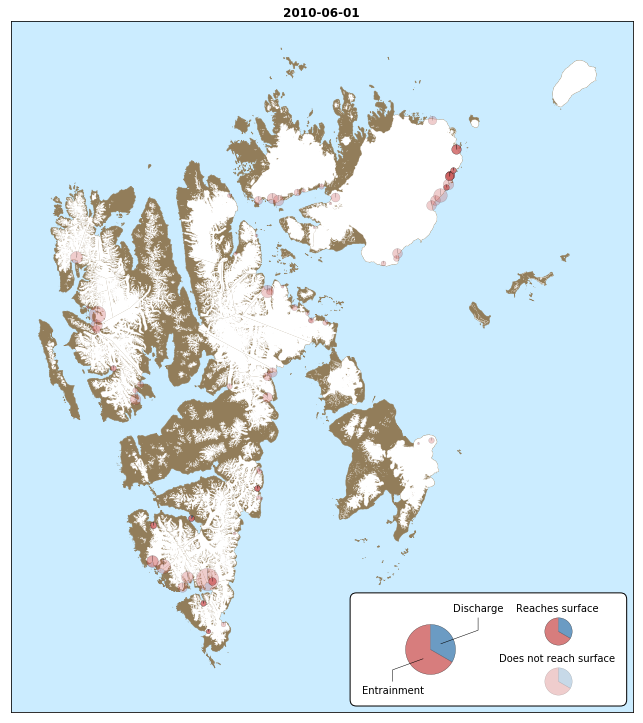

In [44]:
# create figure axes to plot to
fig, ax = plt.subplots(figsize=(10,10))

# use sval map to plot svalbard shapefiles
ax = svalmap.sval_plot(ax=ax)

# reset x/y lims to cut off bjørnøya :'(
ax.set_xlim(380000, 875000)
ax.set_ylim(8450000, 9000000)
#379564.95149999997, 877640.0785

# select colours for pie chart sections
colors = ['indianred','steelblue']

# get a list of dates from one of the glaciers and sort 
# (all glaciers should have the same list of dates)
str_id = '0793'
dates = res_dict2[str_id]['Results'].keys()
dates.sort()

# select a time period if desired (or just comment out for everything)
dates = [d for d in dates if '2010' in d
                          # add extra days/month like:
                          # or '2010-07' in d
                          # or '2010-08-10' in d
        ]

# initialise a list to store PathCollection (scatter plot) objects for animation
scat_list = np.array([[None, None]]*len(res_dict2.keys()))

# animate function to call at each timestep, called in animation.FuncAnimation call below
def animate(count):
    
    # get the current date
    date = dates[count]
    
    # set the plot title as the date
    ax.set_title(date, weight='bold')
    
    # loop through all glacier ids
    for i, str_id in enumerate(res_dict2.keys()):
        
        # safety check, skip if date doesn't exist for this glacier
        if date not in res_dict2[str_id]['Results'].keys():
            for j in range(len(scat_list[i])):
                if scat_list[i][j] is not None:
                    scat_list[i][j].remove()
                    scat_list[i][j] = None  
            continue
        
        # if there isn't any discharge we should also skip
        if 'disch' not in res_dict2[str_id]['Results'][date]:
            for j in range(len(scat_list[i])):
                if scat_list[i][j] is not None:
                    scat_list[i][j].remove()
                    scat_list[i][j] = None  
            continue
        
        # get the discharge
        disch = res_dict2[str_id]['Results'][date]['disch']

        # get entrained volume
        entrained = res_dict2[str_id]['Results'][date]['entrained']
        
        # calculate the surface flux
        surf_flux = disch + entrained

        # set the size for the marker - flux on it's own seems to work fairly nicely
        size = surf_flux

        # ratios sets the relative sizes of the pie slices
        # set to entrained vs discharge
        ratios = [entrained/surf_flux, disch/surf_flux]

        # magic for making a scatter plot look like a pie chart
        # based on: https://matplotlib.org/gallery/api/scatter_piecharts.html       
        xy = []
        
        start = 0.25
        for ratio in ratios:
            x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
            y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
            xy1 = zip(x,y)
            xy.append(xy1)
            start += ratio
        
        # set the transparency based on whether the plume reaches the surface or not
        if res_dict2[str_id]['Results'][date]['surf_flag']:
            alpha = 0.8
        else:
            alpha = 0.3
        
        # now plot
        for j, xyi in enumerate(xy):
            # this deletes the scatter plot from the timestep plot (if there is one)
            if scat_list[i][j] is not None:
                scat_list[i][j].remove()
                scat_list[i][j] = None
            
            # now plot the new pie chart
            scat_list[i][j] = ax.scatter(res_dict2[str_id]['Easting'], 
                                         res_dict2[str_id]['Northing'], 
                                         marker=(xyi,0), s=size, 
                                         facecolor=colors[j],
                                         edgecolor='k',
                                         lw=0.3,
                                         alpha=alpha)

####################
# Plot setup

# Currently this is a bit arbitrarily hard coded for the coord system
# Try just changing the corner coords if you want to move it
# it won't scale well if you try and make it bigger/smaller

# define lower left coords and width/height of box
llx = 650000.
lly = 8455000.
width = 220000.
height = 90000.

left_col_centre = llx + 0.29*width
right_col_centre = llx + 0.75*width

# draw a box for the legend to go in and add it to the axes
fancybox = mpatches.FancyBboxPatch(
    [llx, lly], width, height,
    boxstyle=mpatches.BoxStyle("Round", rounding_size=5000.),
    ec="k", fc="w")
ax.add_patch(fancybox)

# generate a fake pie chart which can be used in the legend
ratios = [2./3., 1./3.]

xy = []            
           
start = 0.25
for ratio in ratios:
    x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
    y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
    xy1 = zip(x,y)
    xy.append(xy1)
    start += ratio

# now plot three versions of the new pie chart with different properties
for j, xyi in enumerate(xy):

    # big one
    ax.scatter(left_col_centre, lly + 45000.,
               marker=(xyi,0), s=2500, 
               facecolor=colors[j],
               edgecolor='k',
               lw=0.3,
               alpha=0.8,
               zorder=2)
    
    # small surfacing
    ax.scatter(right_col_centre, lly + 60000.,
               marker=(xyi,0), s=750, 
               facecolor=colors[j],
               edgecolor='k',
               lw=0.3,
               alpha=0.8,
               zorder=2)
    
    # small no-surfacing
    ax.scatter(right_col_centre, lly + 20000., 
               marker=(xyi,0), s=750, 
               facecolor=colors[j],
               edgecolor='k',
               lw=0.3,
               alpha=0.3,
               zorder=2)

# labels for the large pie plot    
ax.annotate('Discharge', 
            # start line
            np.mean(xy[1], axis=0)*10000. + [left_col_centre, lly + 45000.],
            # text position
            [left_col_centre + 38000., lly + 75000],
            arrowprops=dict(arrowstyle= "-",
                            connectionstyle= "angle,angleA=-90,angleB=20,rad=0",
                            lw=0.5),
            ha='center')

ax.annotate('Entrainment',
            # start line
            np.mean(xy[0], axis=0)*10000. + [left_col_centre - 1000., lly + 40000.],
            # text position
            [left_col_centre - 30000, lly + 10000],
            arrowprops=dict(arrowstyle= "-",
                            connectionstyle= "angle,angleA=-90,angleB=20,rad=0",
                            lw=0.5),
            ha='center')

# title for the smaller pie plots
ax.annotate('Reaches surface', 
            (right_col_centre, lly + 75000.), ha='center')

ax.annotate('Does not reach surface', 
            (right_col_centre, lly + 35000.), ha='center')

# let's turn the axes + labels off so it's a bit prettier
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# remove some whitespace around the plot
plt.tight_layout()

# end plot setup
##############################

# now generate the animation
anim = animation.FuncAnimation(fig, animate, frames = len(dates), interval = 150)

# this line plots shows the animation inline in a jupyter notebook
HTML(anim.to_html5_video())

#### Save animation (gif/avi/mp4 are all available...)

In [46]:
anim.save('svalbard_plumes_2010.gif', writer='imagemagick')

# mp4 example:
# anim.save('svalbard_plumes_2010.mp4', dpi=300, bitrate=1800)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


# Testing section

The following few cells can be used for testing the sensitivity to different ocean properties. They are run by taking a percentage of the maximum discharge for each glacier.

#### Warning! 
These are left here as they may be helpful for sensitivity testing, but be warned they may need updating to reflect other changes in the code in order to run. They are also not as well commented as other sections of the code.

### Run the model for the test cases

In [139]:
# get a list of glaciers with available TS properties
ts_files = os.listdir(ts_folder)

# extract list of ids from file names
ts_ids = [name[3:7] for name in ts_files]

res_dict = {}

for str_id in ts_ids[:2]:
    
    # generate file name
    ts_fname = id_to_fname(str_id)
    
    # load the TS properties as a dataframe
    ts_df = roms_csv_to_df(ts_fname)
    
    # extract the corresponding properties for this glacier    
    glacier_properties = disch_df.loc[disch_df['Drainage_basin_ii']==id_str_to_int(str_id)]
    
    # get depth from disch dataframe (two options here depending on which depth we want to use)
    h_w = glacier_properties[['TW_2015_mean_depth','Depth']].abs().values[0].max()
    
    # cycle through years
    for period in np.unique(ts_df.columns.get_level_values(0)):
    
        print str_id, period
        ambient = pyplume.Ambient(h_w, ts_df[period]['salt'].values, ts_df[period]['temp'].values, 
                                  depth = ts_df.index.values)

        #disch = glacier_properties['Q_max'].values[0]
        for disch_perc in [1.,5.,10.,50.,100.]:
            
            disch = glacier_properties.iloc[0]['Q_max'] * disch_perc/100.
            
            str_disch = "%.2f"%disch
        
            rad, vel = pyplume.inlet(h_w+40., h_w, disch)

            plume = pyplume.calc_plume(vel, rad, h_w, ambient, MELT=True)

            plume = {k: np.array(plume[k]) for k in plume.keys()}

            plume = add_buoyancy_flux(plume)

            if str_id in res_dict.keys():
                if period in res_dict[str_id].keys():
                    res_dict[str_id][period][str_disch] = plume
                else:
                    res_dict[str_id][period] = {str_disch: plume}
            else:
                res_dict[str_id] = {period: {str_disch: plume}}


0584 2007-06
0584 2007-07
0584 2007-08
0584 2007-09
0584 2008-06
0584 2008-07
0584 2008-08
0584 2008-09
0584 2009-06
0584 2009-07
0584 2009-08
0584 2009-09
0584 2010-06
0584 2010-07
0584 2010-08
0584 2010-09
0793 2007-06
0793 2007-07
0793 2007-08
0793 2007-09
0793 2008-06
0793 2008-07
0793 2008-08
0793 2008-09
0793 2009-06
0793 2009-07
0793 2009-08
0793 2009-09
0793 2010-06
0793 2010-07
0793 2010-08
0793 2010-09


### Plotting results from previous steps:

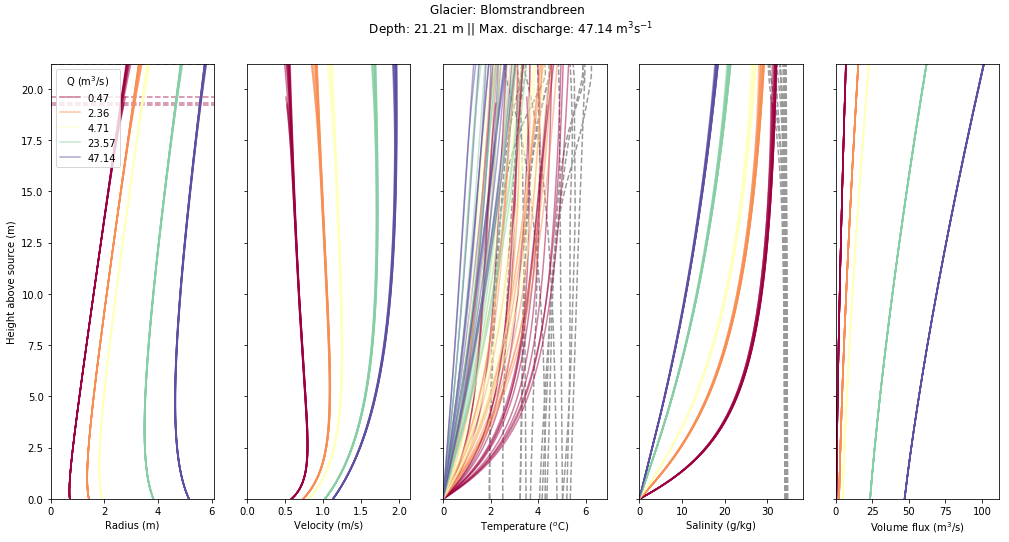

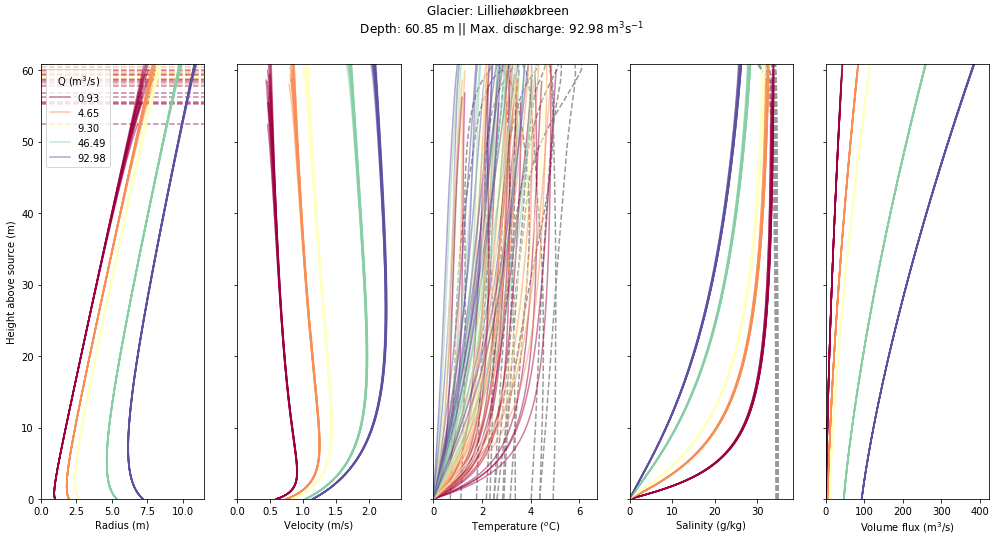

In [168]:
cmap = matplotlib.cm.get_cmap('Spectral')

for db_id in res_dict.keys():
    
    f,ax = plt.subplots(1,5, sharey=True, figsize=(17,8))
    
    glacier_properties = disch_df[disch_df['Drainage_basin_ii']==int(db_id)]
    
    f.suptitle("Glacier: %s \n Depth: %.2f m || Max. discharge: %.2f m$^3$s$^{-1}$"
               %(glacier_properties['TW_2015_name'].to_string(index=False),
                glacier_properties['TW_2015_mean_depth'].abs(),
                glacier_properties['Q_max']))
    
    legend = None
    
    period_range = res_dict[db_id].keys()
    
    #col_iter = iter(cmap(np.linspace(0,1,len(period_range))))
    
    for period in period_range:

        disch_range = res_dict[db_id][period].keys()
        
        col_iter = iter(cmap(np.linspace(0,1,len(disch_range))))
        #col = col_iter.next()
        for disch in sorted(disch_range, key=float):
            
            col = col_iter.next()
            
            #col[-1] = alpha
        
            plume = res_dict[db_id][period][disch]
            nb_depth = neutral_buoyancy_depth(plume)
            plume = add_momentum_flux(plume)

            # radius
            ax[0].plot(plume['b_p'], plume['z'], '-', c=col, label="%s"%disch, alpha=0.5)
            ax[0].set_xlim(0, np.nanmax([ax[0].get_xlim()[1], plume['b_p'].max()]))
            ax[0].plot([0, 100], [nb_depth, nb_depth], '--', c=col, alpha=0.5, zorder=0.9)
            
            # velocity
            ax[1].plot(plume['w_p'], plume['z'], '-', c=col, alpha=0.5)

            # temperature
            ax[2].plot(plume['t_p'], plume['z'], '-', c=col, alpha=0.5)

            # salinity
            ax[3].plot(plume['s_p'], plume['z'], '-', c=col, alpha=0.5)
            
            ax[4].plot(0.5*math.pi*plume['b_p']**2.*plume['w_p'], plume['z'], '-', c=col, alpha=0.5)
      
        ax[2].plot(plume['t_a'], plume['z'], '--', c='0.6', zorder=0.9)        
        ax[3].plot(plume['s_a'], plume['z'], '--', c='0.6', zorder=0.9)
        
        if legend == None:
            legend = ax[0].legend(title='Q (m$^3$/s)')
            
    ax[0].set_xlabel('Radius (m)')
    ax[0].set_ylabel('Height above source (m)')
    ax[0].set_ylim(0, glacier_properties['TW_2015_mean_depth'].abs().values[0])
    
    ax[1].set_xlabel('Velocity (m/s)')

    ax[2].set_xlabel('Temperature ($^o$C)')    

    ax[3].set_xlabel('Salinity (g/kg)')
    
    ax[4].set_xlabel('Volume flux (m$^3$/s)')
    
    for axis in ax:
        axis.set_xlim(0, axis.get_xlim()[1]*1.05)
    plt.savefig(db_id+'.jpg',dpi=600)

### Some different plotting!

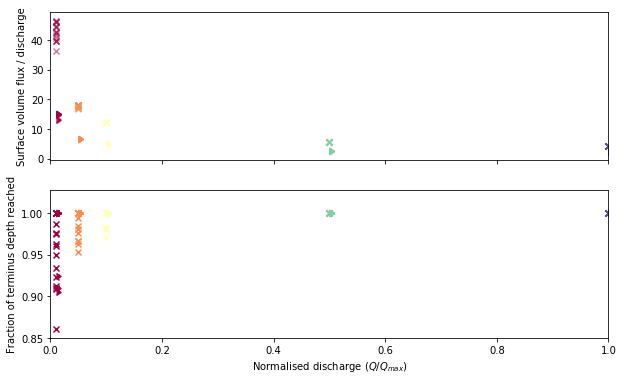

In [169]:
cmap = matplotlib.cm.get_cmap('Spectral')

f,ax = plt.subplots(2,1, sharex=True, figsize=(10,6))

id_range = res_dict.keys()

shape_iter = iter(matplotlib.markers.MarkerStyle.markers.keys()[13:])

for db_id in id_range:
    
    shape = shape_iter.next()
        
    glacier_properties = disch_df[disch_df['Drainage_basin_ii']==int(db_id)]
  
    period_range = res_dict[db_id].keys()

    for period in period_range:
        
        disch_range = res_dict[db_id][period].keys()
        
        col_iter = iter(cmap(np.linspace(0,1,len(disch_range))))
        
        for disch in sorted(disch_range, key=float):
        
            col = col_iter.next()
            
            plume = res_dict[db_id][period][disch]

            surface_flux = np.nanmax(0.5*math.pi*plume['b_p']**2.*plume['w_p'])
            
            fraction_of_depth = neutral_buoyancy_depth(plume)/abs(glacier_properties.iloc[0]['TW_2015_mean_depth'])
            
            if fraction_of_depth == 1.0:
                alpha = 1.
            else:
                alpha = 0.5
                
            ax[0].scatter(float(disch)/glacier_properties.iloc[0]['Q_max'],
                        surface_flux/(float(disch)),
                        c=col, marker=shape, alpha=alpha)
                
            ax[1].scatter(float(disch)/glacier_properties.iloc[0]['Q_max'], 
                        neutral_buoyancy_depth(plume)/abs(glacier_properties.iloc[0]['TW_2015_mean_depth']), 
                        c=col, marker=shape)

            #print glacier_properties['Q_max'].values, np.nanmax(plume['F_p'])

ax[0].set_ylabel('Surface volume flux / discharge')
ax[0].set_xlim(0,1)

ax[1].set_xlabel('Normalised discharge ($Q/Q_{max}$)')
ax[1].set_ylabel('Fraction of terminus depth reached')

### This is the equivalent of the previous cells, but does it in a single for loop, rather than running saving results, then looping through results and plotting

0584 2007-06


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


0584 2007-07
0584 2007-08
0584 2007-09
0584 2008-06
0584 2008-07
0584 2008-08
0584 2008-09


KeyboardInterrupt: 

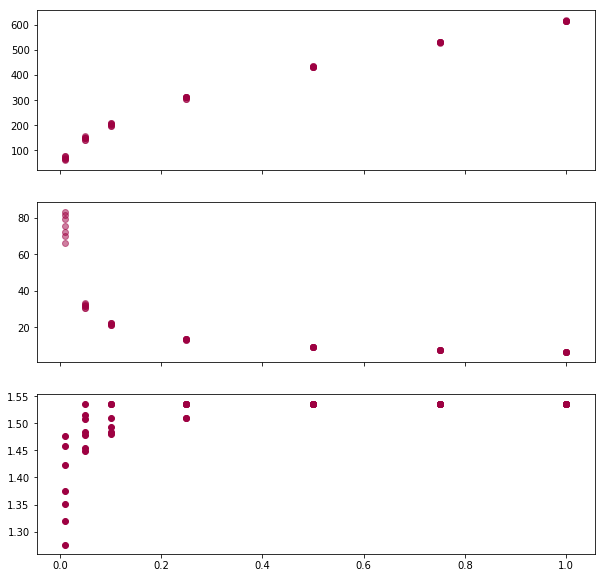

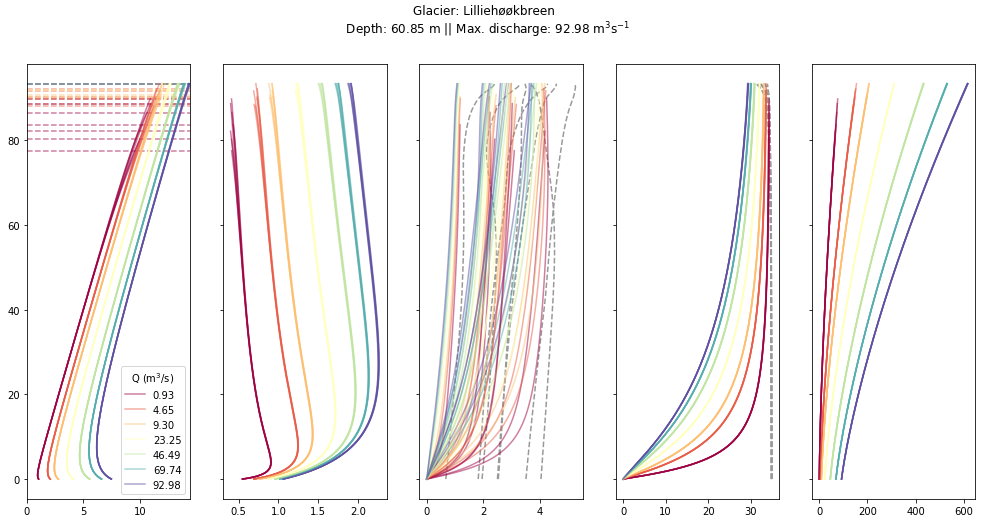

In [5]:
cmap = matplotlib.cm.get_cmap('Spectral')

shape_iter = iter(matplotlib.markers.MarkerStyle.markers.keys()[13:])

ts_folder = 'inputs/ts_roms/'

# get a list of glaciers with available TS properties
ts_files = os.listdir(ts_folder)

# extract list of ids from file names
ts_ids = [name[3:7] for name in ts_files]

all_f,all_ax = plt.subplots(3,1, sharex=True, figsize=(10,10))

id_range = ts_ids[:2]

id_iter = iter(cmap(np.linspace(0,1,len(id_range))))

res_dict = {}

for str_id in id_range:
    
    id_col = id_iter.next()
    
    # extract the corresponding properties for this glacier    
    glacier_properties = disch_df.loc[disch_df['Drainage_basin_ii']==id_str_to_int(str_id)]    
    
    #############
    # from plotting 1
    f,ax = plt.subplots(1,5, sharey=True, figsize=(17,8))
    
    #glacier_properties = disch_df[disch_df['Drainage_basin_ii']==int(db_id)]
    
    f.suptitle("Glacier: %s \n Depth: %.2f m || Max. discharge: %.2f m$^3$s$^{-1}$"
               %(glacier_properties['TW_2015_name'].to_string(index=False),
                glacier_properties['TW_2015_mean_depth'].abs(),
                glacier_properties['Q_max']))
    
    legend = None
    
    #period_range = res_dict[db_id].keys()
    
    #############
    
    # generate file name
    ts_fname = id_to_fname(str_id)
    
    # load the TS properties as a dataframe
    ts_df = roms_csv_to_df(ts_fname)
    
    # get depth from disch dataframe 
    # take the max of the two available depths
    h_w = glacier_properties[['TW_2015_mean_depth','Depth']].abs().values[0].max()
    
    period_range = np.unique(ts_df.columns.get_level_values(0))
    
    period_iter = iter(cmap(np.linspace(0,1,len(period_range))))
    
    # cycle through years
    for period in period_range:
    
        print str_id, period
        
        period_col = period_iter.next()
        
        disch_range = [1.,5.,10.,25.,50.,75.,100.]
        
        disch_iter = iter(cmap(np.linspace(0,1,len(disch_range))))
        
        ambient = pyplume.Ambient(h_w, 
                                  ts_df[period]['salt'].values, 
                                  ts_df[period]['temp'].values, 
                                  depth = ts_df.index.values)

        #disch = glacier_properties['Q_max'].values[0]
        for disch_perc in disch_range:
            
            disch_col = disch_iter.next()            
            
            disch = glacier_properties.iloc[0]['Q_max'] * disch_perc/100.
            
            str_disch = "%.2f"%disch
        
            rad, vel = pyplume.inlet(h_w+40., h_w, disch)

            plume = pyplume.calc_plume(vel, rad, h_w, ambient, MELT=True)

            # json can't take numpy arrays, so extract some results now
            # for now, let's just store surface properties, otherwise the results are huge
            surf_dict = {k: plume[k][-1] for k in plume.keys()}

            plume = {k: np.array(plume[k]) for k in plume.keys()}

            plume = add_buoyancy_flux(plume)
            
            nb_depth = neutral_buoyancy_depth(plume)

            # add nb_depth to surface dict, so we have something if the plume didn't reach
            # the surface
            surf_dict['nb'] = nb_depth
            
            # build results dict
            if str_id in res_dict.keys():
                if period in res_dict[str_id].keys():
                    res_dict[str_id][period][str_disch] = surf_dict
                else:
                    res_dict[str_id][period] = {str_disch: surf_dict}
            else:
                res_dict[str_id] = {period: {str_disch: surf_dict}}
                
            # radius
            ax[0].plot(plume['b_p'], plume['z'], '-', c=disch_col, label="%.2f"%disch, alpha=0.5)
            ax[0].set_xlim(0, np.nanmax([ax[0].get_xlim()[1], plume['b_p'].max()]))
            ax[0].plot([0, 100], [nb_depth, nb_depth], '--', c=disch_col, alpha=0.5, zorder=0.9)
            
            # velocity
            ax[1].plot(plume['w_p'], plume['z'], '-', c=disch_col, alpha=0.5)

            # temperature
            ax[2].plot(plume['t_p'], plume['z'], '-', c=disch_col, alpha=0.5)

            # salinity
            ax[3].plot(plume['s_p'], plume['z'], '-', c=disch_col, alpha=0.5)
            
            ax[4].plot(0.5*math.pi*plume['b_p']**2.*plume['w_p'], plume['z'], '-', c=disch_col, alpha=0.5)

            surface_flux = np.nanmax(0.5*math.pi*plume['b_p']**2.*plume['w_p'])
            
            fraction_of_depth = neutral_buoyancy_depth(plume)/abs(glacier_properties.iloc[0]['TW_2015_mean_depth'])
            
            if fraction_of_depth == 1.0:
                alpha = 1.
            else:
                alpha = 0.5
                
            all_ax[0].scatter(float(disch)/glacier_properties.iloc[0]['Q_max'],
                        surface_flux,
                        c=id_col, alpha=alpha)
            
            all_ax[1].scatter(float(disch)/glacier_properties.iloc[0]['Q_max'],
                        surface_flux/(float(disch)),
                        c=id_col, alpha=alpha)
                
            all_ax[2].scatter(float(disch)/glacier_properties.iloc[0]['Q_max'], 
                        neutral_buoyancy_depth(plume)/abs(glacier_properties.iloc[0]['TW_2015_mean_depth']), 
                        c=id_col)                
                
        ax[2].plot(plume['t_a'], plume['z'], '--', c='0.6', zorder=0.9)        
        ax[3].plot(plume['s_a'], plume['z'], '--', c='0.6', zorder=0.9)
        
        if legend == None:
            legend = ax[0].legend(title='Q (m$^3$/s)')
            
    all_ax[0].scatter([], [], c=id_col, label=str_id)
            
    ax[0].set_xlabel('Radius (m)')
    ax[0].set_ylabel('Height above source (m)')
    ax[0].set_ylim(0, glacier_properties['TW_2015_mean_depth'].abs().values[0])
    
    ax[1].set_xlabel('Velocity (m/s)')

    ax[2].set_xlabel('Temperature ($^o$C)')    

    ax[3].set_xlabel('Salinity (g/kg)')
    
    ax[4].set_xlabel('Volume flux (m$^3$/s)')
    
    for axis in ax:
        axis.set_xlim(0, axis.get_xlim()[1]*1.05)
    f.savefig(str_id+'.jpg',dpi=300)

all_ax[0].legend(title='Drainage Basin ID')
    
all_ax[1].set_ylabel('Surface volume flux / discharge')
all_ax[1].set_xlim(0,1)

all_ax[2].set_xlabel('Normalised discharge ($Q/Q_{max}$)')
all_ax[2].set_ylabel('Fraction of terminus depth reached')

all_f.savefig('compare.jpg',dpi=300)